CW_Folder_UG/Code/HOG_SVM.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opencv-python==4.5.5.64

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 8.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.7.0.72
    Uninstalling opencv-python-4.7.0.72:
      Successfully uninstalled opencv-python-4.7.0.72


In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the lab materials
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Lab materials 01-20210104'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/CW_Folder_UG' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Code', 'Personal_Dataset', 'Models', 'CW_Dataset', 'test_functions.ipynb']


Copying and unzipping the dataset zip file for faster reading (from Lab 7)


In [ ]:
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/CV2023_CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CV2023_CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CV2023_CW_Dataset.zip

In [ ]:
# loading files taken from https://stackoverflow.com/questions/273192/how-can-i-safely-create-a-directory-possibly-including-intermediate-directories
from pathlib import Path
import shutil
import os

def dataFolder(trainImagePath, testImagePath):
  Path("./Data").mkdir(parents=True, exist_ok=True)
  Path("./Data/train").mkdir(parents=True, exist_ok=True)
  Path("./Data/test").mkdir(parents=True, exist_ok=True)

  # Creating folders for all labels (0-not wearing mask, 1-wearing mask properly, 2- wearing mask inproperly)
  for n in range(3):
    Path(f"./Data/train/{n}").mkdir(parents=True, exist_ok=True)
    Path(f"./Data/test/{n}").mkdir(parents=True, exist_ok=True)

  # Initialisng train and test path
  trainPath = './Data/train'
  testPath = './Data/test'

 # Reading the text file names and the number within the text file in train folder to match with the name of the image
  file_names = [file for file in os.listdir(trainImagePath) if file.endswith('.jpeg')]
  # print(file_names)
  label_files = os.listdir('./train/labels')
  parsed_data = {x.removesuffix(".txt") + ".jpeg":open('./train/labels/' + x, "r").read().strip() for x in label_files}
  # Putting the images into assigned folders for train folder
  for file in file_names:
    shutil.copy(f"{trainImagePath}/{file}", f"{trainPath}/{parsed_data[file.replace('_aligned', '')]}/{file}")

 # Reading the text file names and the number within the text file in test folder to match with the name of the image
  file_names = [file for file in os.listdir(testImagePath) if file.endswith('.jpeg')]
  label_files = os.listdir('./test/labels')
  parsed_data = {x.removesuffix(".txt") + ".jpeg":open('./test/labels/' + x, "r").read().strip() for x in label_files} 
  # Putting the images into assigned folders for test folder
  for file in file_names:
    shutil.copy(f"{testImagePath}/{file}", f"{testPath}/{parsed_data[file.replace('_aligned', '')]}/{file}")

In [ ]:
# Loading the folders
dataFolder('./train/images', './test/images')

In [ ]:
# Importing libraries

import cv2
import numpy as np
from sklearn.svm import SVC
from skimage.feature import hog
from skimage import data, exposure
import matplotlib.pyplot as plt
from joblib import dump, load
import os
import ast
import random

import torch
from torch.nn.utils.rnn import pad_sequence

Data loading and HOG extraction (From lab 6 and 7 and adjusted for HOG and from https://debuggercafe.com/image-recognition-using-histogram-of-oriented-gradients-hog-descriptor/ )

In [ ]:
def extract_hog_features(image):
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Compute HOG features
    features, hog_image = hog(gray_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=False)
    
    return features, hog_image

In [ ]:
# Data loader function
def load_images_from_folder(folder):
    # Initialize lists for storing images and labels
    images = []
    labels = []
    hog_images = []
    # Loop through each subfolder in the folder
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        # Loop through each image in the subfolder
        for filename in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, filename)
            # Load image
            img = cv2.imread(img_path)
            # Extract HOG features
            hog_features, hog_image = extract_hog_features(img)
            # Add image and label to the lists
            images.append(torch.tensor(hog_features))
            labels.append(int(subfolder))
            hog_images.append(hog_image)
            
    
    # Padding using pytorch pad sequence from PyTorch documentation https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html
    padded_tensors = pad_sequence(images,batch_first=True, padding_value=0)
    hog_images = np.array(hog_images, dtype=object)
    padded_numpy_array = padded_tensors.numpy()
    return padded_numpy_array , labels, hog_images

In [ ]:
# Load training data
train_folder = 'Data/train'
train_images, train_labels, train_hog_images = load_images_from_folder(train_folder)

# Load testing data
test_folder = 'Data/test'
test_images, test_labels, test_hog_images = load_images_from_folder(test_folder)

<ipython-input-8-08e3e4c073ac>:5: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features, hog_image = hog(gray_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=False)


Showing first four HOG images (From lab 7)

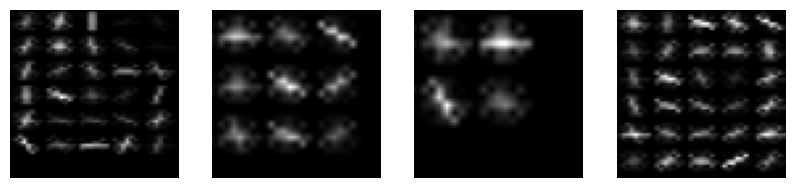

In [ ]:
from skimage.transform import resize

# Define the target size for the images
target_size = (64, 64)

# Visualize the first four HOG images
fig, axs = plt.subplots(1, 4, figsize=(10, 5))
for i in range(4):
    # Resize the image to the target size
    image_resized = resize(train_hog_images[i], target_size, anti_aliasing=True)
    axs[i].imshow(image_resized, cmap='gray')
    axs[i].axis('off')
plt.show()


Checking class distribution

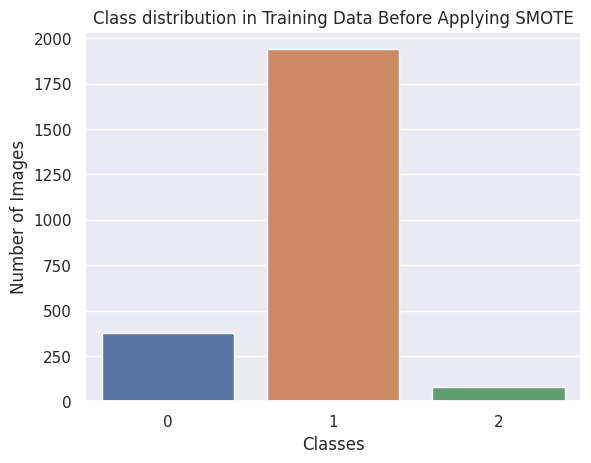

In [ ]:
# craeting bar plot to check distribution in each class
import seaborn as sns
import matplotlib.pyplot as plt

zero_class = len(os.listdir('/content/Data/train/0'))
one_class = len(os.listdir('/content/Data/train/1'))
two_class = len(os.listdir('/content/Data/train/2'))


# create sample data
x = ['0', '1', '2']
y = [zero_class, one_class, two_class]

# create bar plot using Seaborn
sns.set(style='darkgrid')
sns.barplot(x=x, y=y)

# set plot title and axis labels
plt.title('Class distribution in Training Data Before Applying SMOTE')
plt.xlabel('Classes')
plt.ylabel('Number of Images')

# display plot
plt.show()

In [ ]:
print(test_images.shape)
print(train_images.shape)
print(len(train_labels))
print(len(test_labels))
# print(test_images_reshaped.shape)

(458, 35496)
(2394, 56088)
2394
458


Applying SMOTE to an unbalanced dataset and then checking the new distribution (learnt from https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/ which was from the website provided in the lab for unbalanced distribution in lab 7)

In [ ]:
import numpy as np
from imblearn.over_sampling import SMOTE

# Create SMOTE object
sm = SMOTE(random_state=42)

# Convert train_labels to numpy array and reshape to match the number of rows in train_images
train_labels_np = np.array(train_labels)
train_labels_reshaped = train_labels_np.reshape(-1, 1)

# Apply SMOTE to train_images and train_labels
train_images_resampled, train_labels_resampled = sm.fit_resample(train_images, train_labels_reshaped)

# Reshape train_labels back to 1D array
train_labels_resampled = train_labels_resampled.ravel()

# Check the new class distribution
print('Class Distribution after SMOTE:', np.bincount(train_labels_resampled))

# Now train_images_resampled and train_labels_resampled can be used for training the classifier


Class Distribution after SMOTE: [1940 1940 1940]


In [ ]:
print(np.bincount(train_labels_resampled))

[1940 1940 1940]


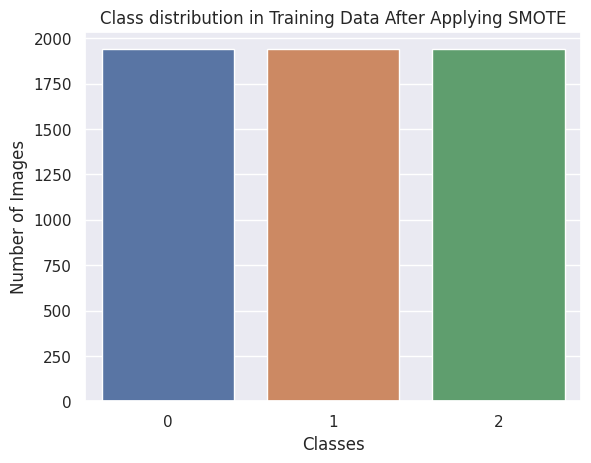

In [ ]:
# Creating bar plot to check distribution in each class
import seaborn as sns
import matplotlib.pyplot as plt

# Create sample data
x = ['0', '1', '2']
y = np.bincount(train_labels_resampled)

# Create bar plot using Seaborn
sns.set(style='darkgrid')
sns.barplot(x=x, y=y)

# Set plot title and axis labels
plt.title('Class distribution in Training Data After Applying SMOTE')
plt.xlabel('Classes')
plt.ylabel('Number of Images')

# Display plot
plt.show()


In [ ]:
# Checking the shapes after resampling
print(train_images_resampled.shape)
print(train_labels_resampled.shape)

(5820, 56088)
(5820,)


Applying SVM classifier (from lab 5 and 7, parameters optimized from previous SVM implememtation in SIFT_SVM grid search example)

In [ ]:
# Create SVM classifier
svm_classifier = SVC(kernel='rbf', gamma= 10, C =10)

# Train SVM classifier
svm_classifier.fit(train_images, train_labels)

# Test SVM classifier
# assume train_images is already loaded with shape (2394, 56088)
# assume test_images is already loaded with shape (458, 35496)

# calculate the total number of features
num_features = train_images.shape[1]

# reshape the test set to match the number of features in the training set
test_images_reshaped = np.zeros((test_images.shape[0], num_features))
test_images_reshaped[:, :test_images.shape[1]] = test_images

svm_score = svm_classifier.score(test_images_reshaped, test_labels)
print('SVM Classifier Accuracy:', svm_score)

SVM Classifier Accuracy: 0.8471615720524017


Plotting confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

# Predict the labels of the test set using the trained SVM classifier
predicted_labels = svm_classifier.predict(test_images_reshaped)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

print('Confusion Matrix:')
print(conf_matrix)


Confusion Matrix:
[[  1  50   0]
 [  1 387   0]
 [  0  19   0]]


Plotting confusion matrix with TP TN FP FN

In [ ]:
# Calculate the total number of true positives, true negatives, false positives, and false negatives for each class
for i in range(len(conf_matrix)):
    tp = conf_matrix[i,i]
    tn = np.sum(conf_matrix) - np.sum(conf_matrix[i,:]) - np.sum(conf_matrix[:,i]) + tp
    fp = np.sum(conf_matrix[:,i]) - tp
    fn = np.sum(conf_matrix [i,:]) - tp
    print("Class {}: TP = {}, TN = {}, FP = {}, FN = {}".format(i, tp, tn, fp, fn))

Class 0: TP = 1, TN = 406, FP = 1, FN = 50
Class 1: TP = 387, TN = 1, FP = 69, FN = 1
Class 2: TP = 0, TN = 439, FP = 0, FN = 19


In [ ]:
# Saving the model into the Model folder (from lab 7)
dump(svm_classifier, os.path.join(GOOGLE_DRIVE_PATH, 'Models/HOG_SVM.joblib')) 

['drive/My Drive/Colab Notebooks/CW_Folder_UG/Models/HOG_SVM.joblib']